# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd
import re
import time
import sklearn.metrics as metrics

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

import spacy
from nltk.corpus import stopwords

import torch
import transformers

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.shape

(47331, 17)

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
# checking for missing values

df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
# duplicates

df_reviews.duplicated().sum()

0

In [10]:
# target

df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

In [11]:
# five point summary

df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


**First Look Summary**

 - There are 47,331 reviews with only two reviews missing in `'average_rating'` and `'votes'`.
 - There are no duplicates.
 - The target `'pos'` appears to be balanced (there are an equal number of positive and negative reviews).
 - The oldest movie review was for a movie released in 1894 and the most recent movie review is in 2010.
 - The overall average rating is 6.3.
 - The number of votes ranges from as few as 9 to over 1.7 million.
 - The individual rating ranges from 1 to 10.

## EDA

Let's check the number of movies and reviews over years.

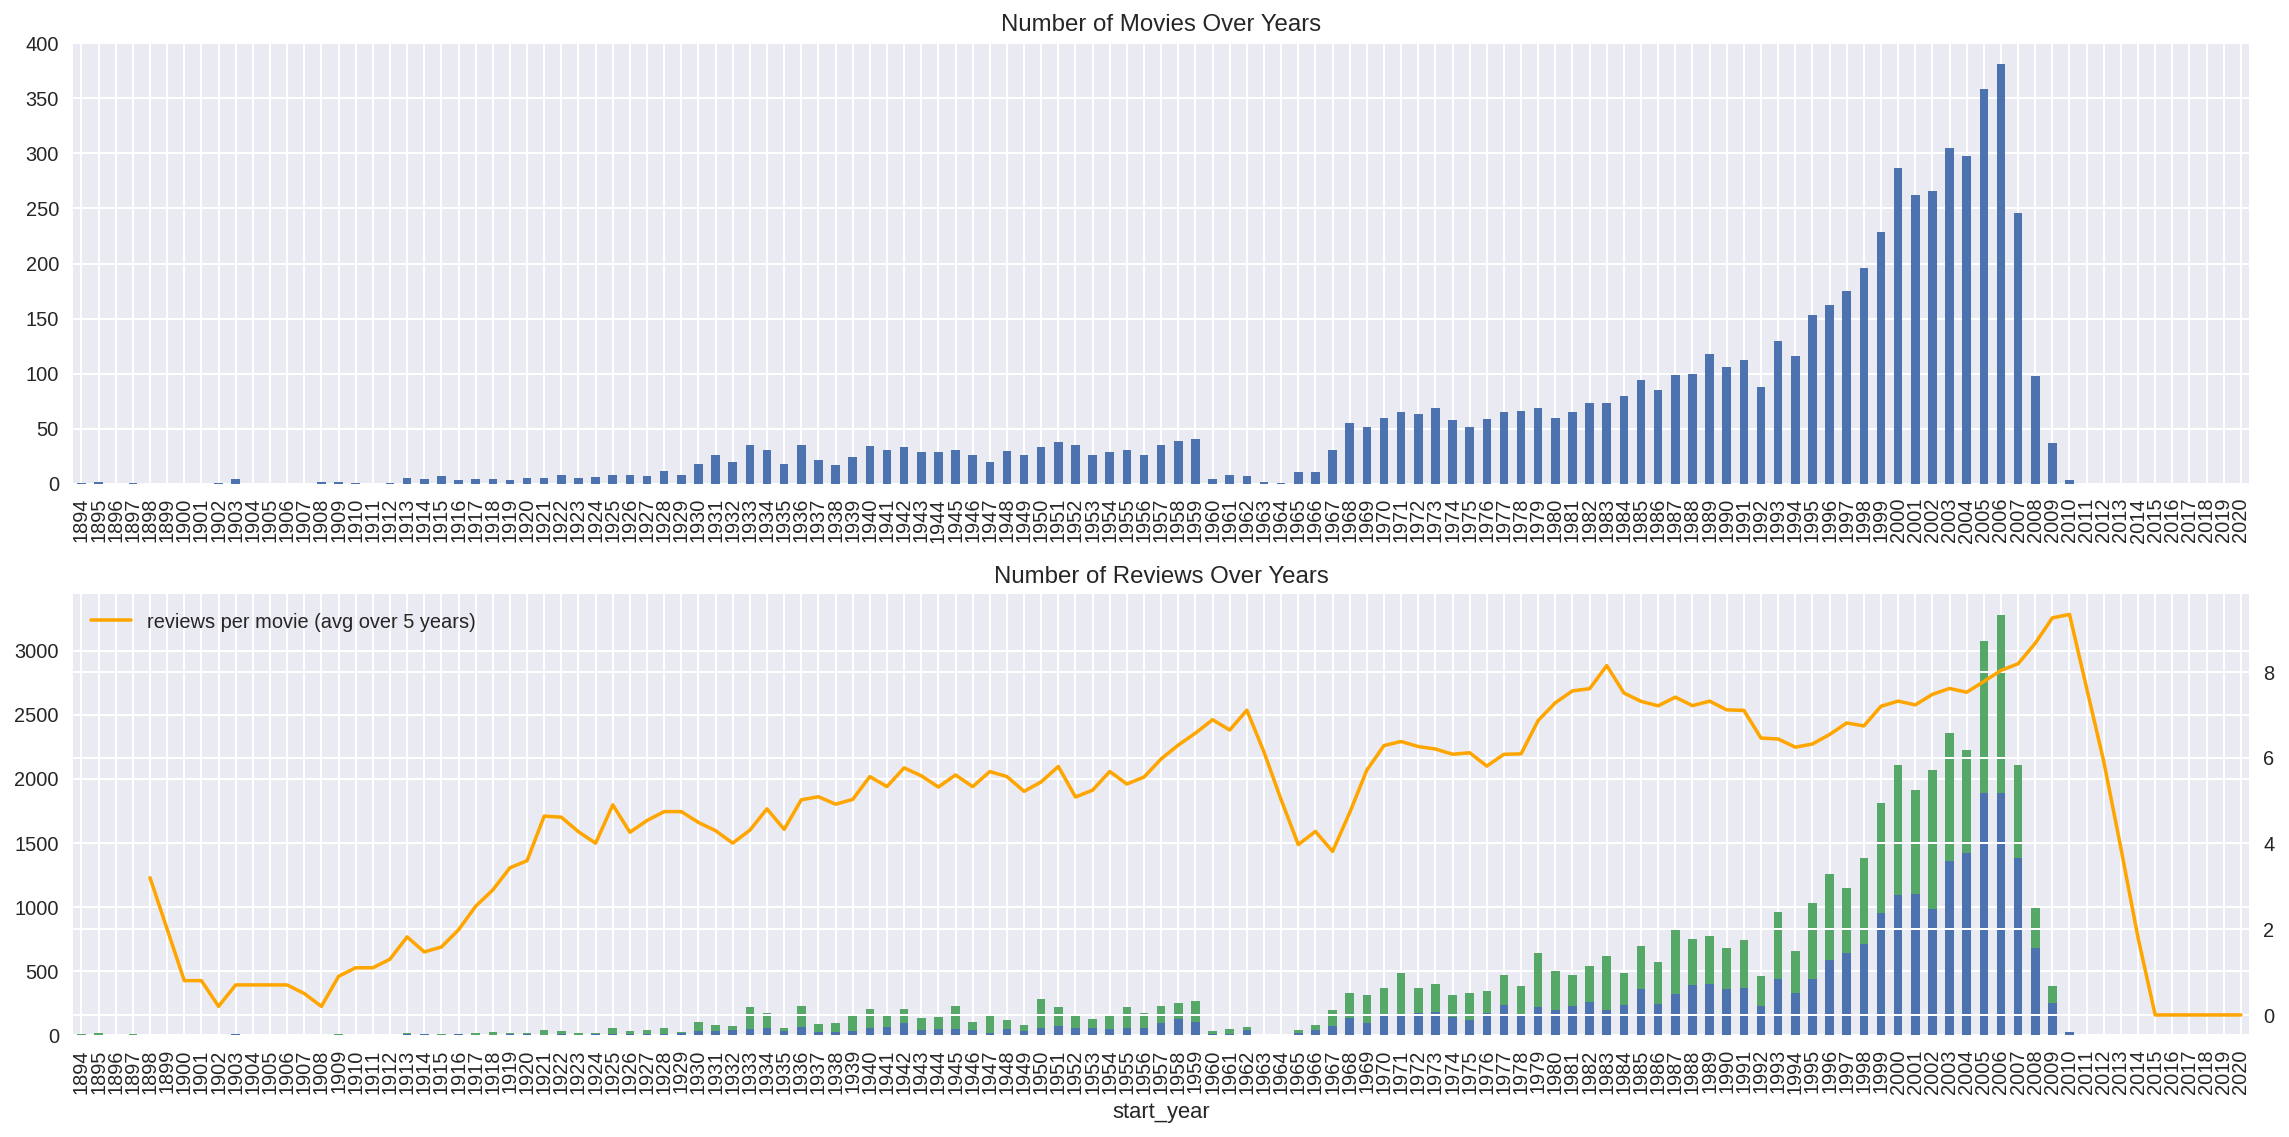

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Most of the reviews during this dataset came out in 2006 (at least 3000 movies).

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

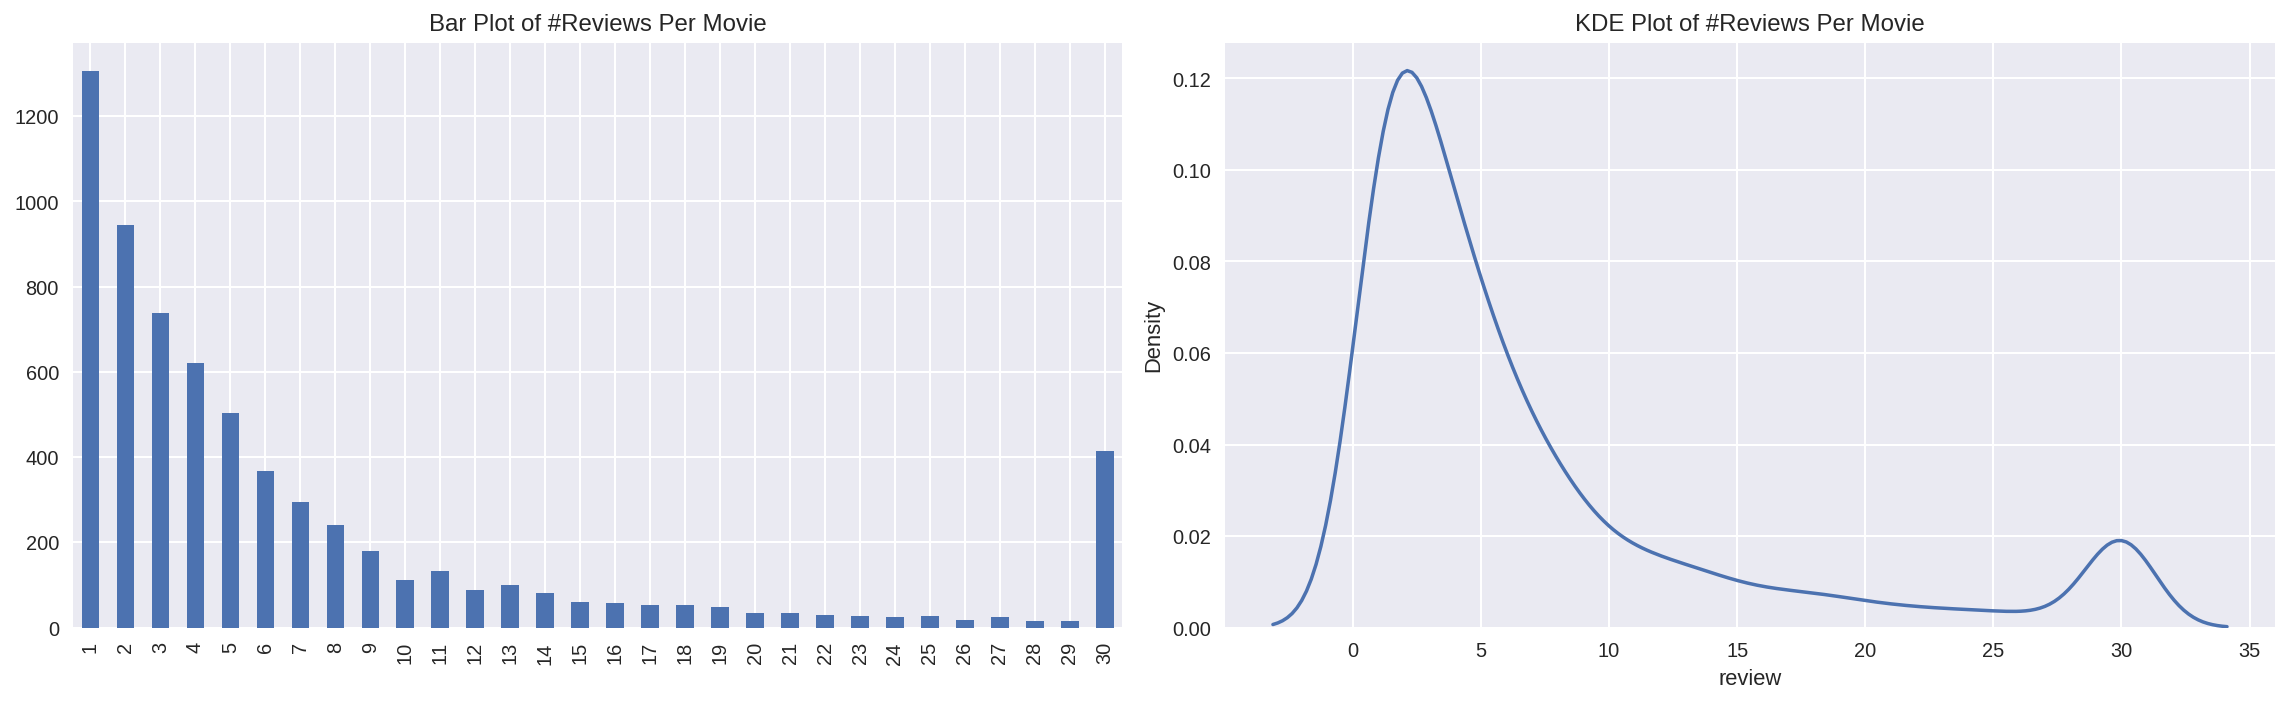

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most of the movies reviewed have received one review with the most reviews received for a movie being 30.

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

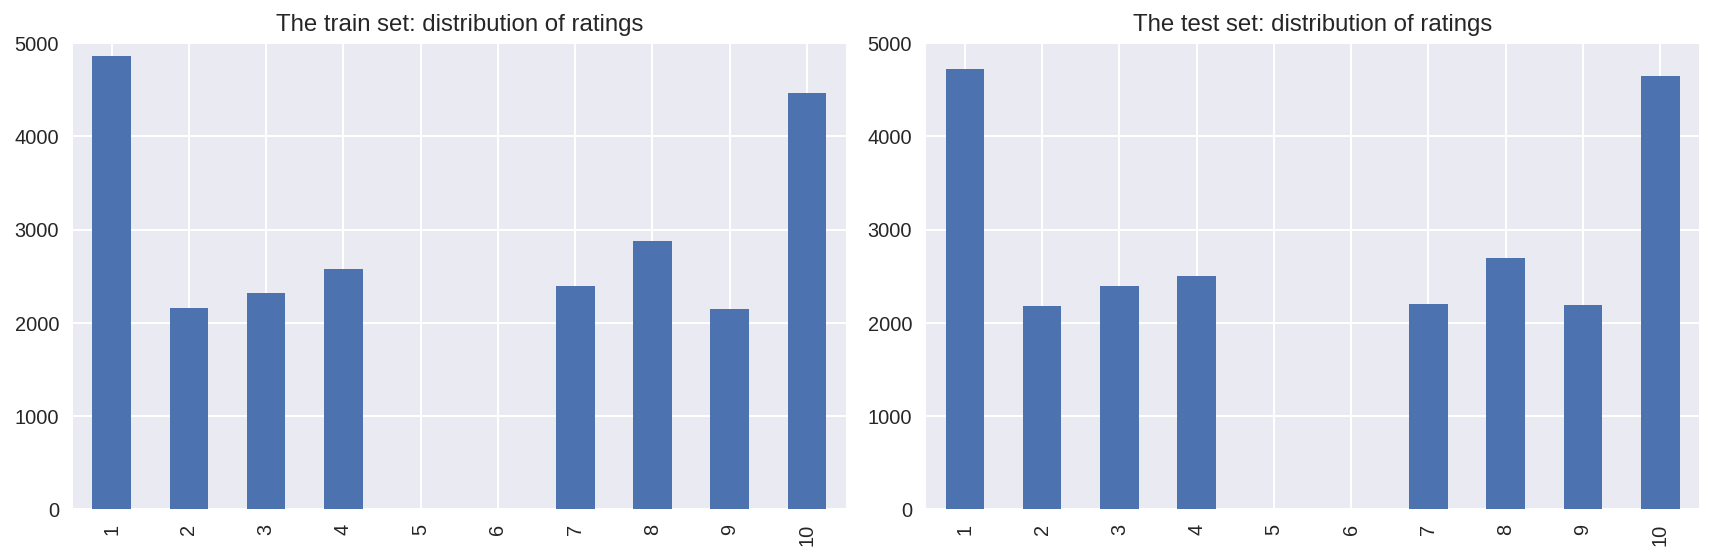

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution in ratings between the train and test sets are very similar with gaps between 5 and 6.

Distribution of negative and positive reviews over the years for two parts of the dataset

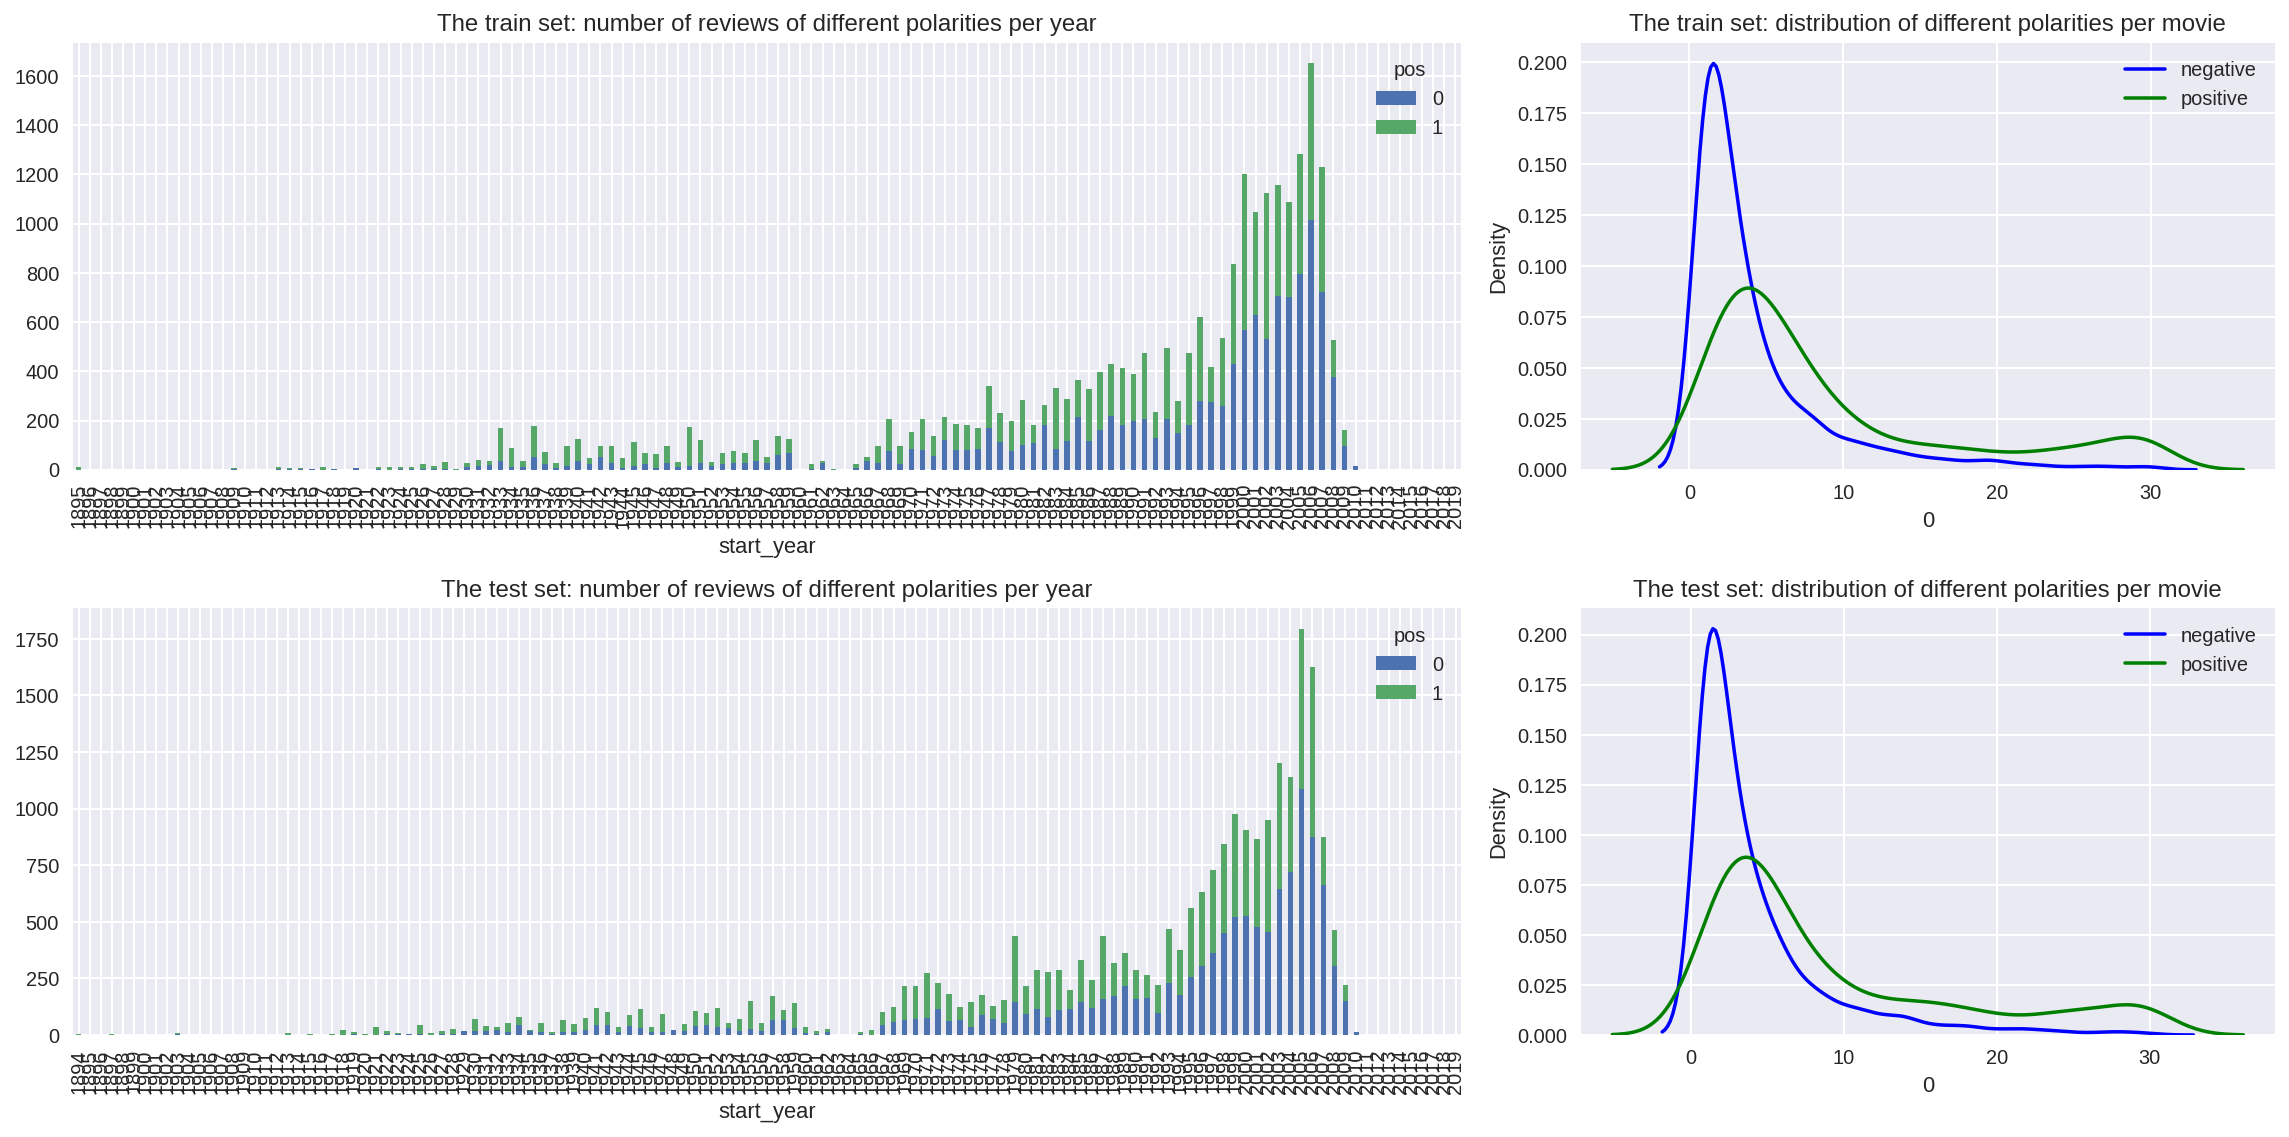

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The distribution between the polarities of reviews between the train and test set look very similar.

**EDA Summary**
 - The classes are balanced.
 - The majority of the movies came out in 2006.
 - Most of the movies have only one review with the most reviews for a movie being 30.
 - The distribution of ratings and in polarities of movie reviews for both the train and test sets are similar.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [17]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
lemmatizer = WordNetLemmatizer()

In [19]:
def clean_reviews(text):
    """
    Clean the review
    https://stackoverflow.com/questions/51784964/remove-emojis-from-multilingual-unicode-text/51785357#51785357
    """
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\']', ' ', text)
    # text = emoji.get_emoji_regexp().sub(u'', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    # text = " ".join(lemmatizer.lemmatize(word) for word in word_tokenize(text))
    text = re.sub(r'\s+', ' ', text)
    return text

In [20]:
df_reviews['reviews_norm'] = df_reviews['review'].apply(clean_reviews)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

In [22]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    """
    Build model
    """
    np.random.seed(1357)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict(train_X)
        best_score = f1_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'lgbm':
        gs.best_estimator_.fit(train_X, train_y, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_score = f1_score(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

### Model 0 - Constant

In [23]:
dc = DummyClassifier()
best_dc_model, best_dc_f1, best_dc_time = build_model(dc, df_reviews_train['reviews_norm'], train_target, 
                                                        df_reviews_test['reviews_norm'], test_target,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=2, model_str='dummy')

In [24]:
# test set

best_dc_f1

0.0

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


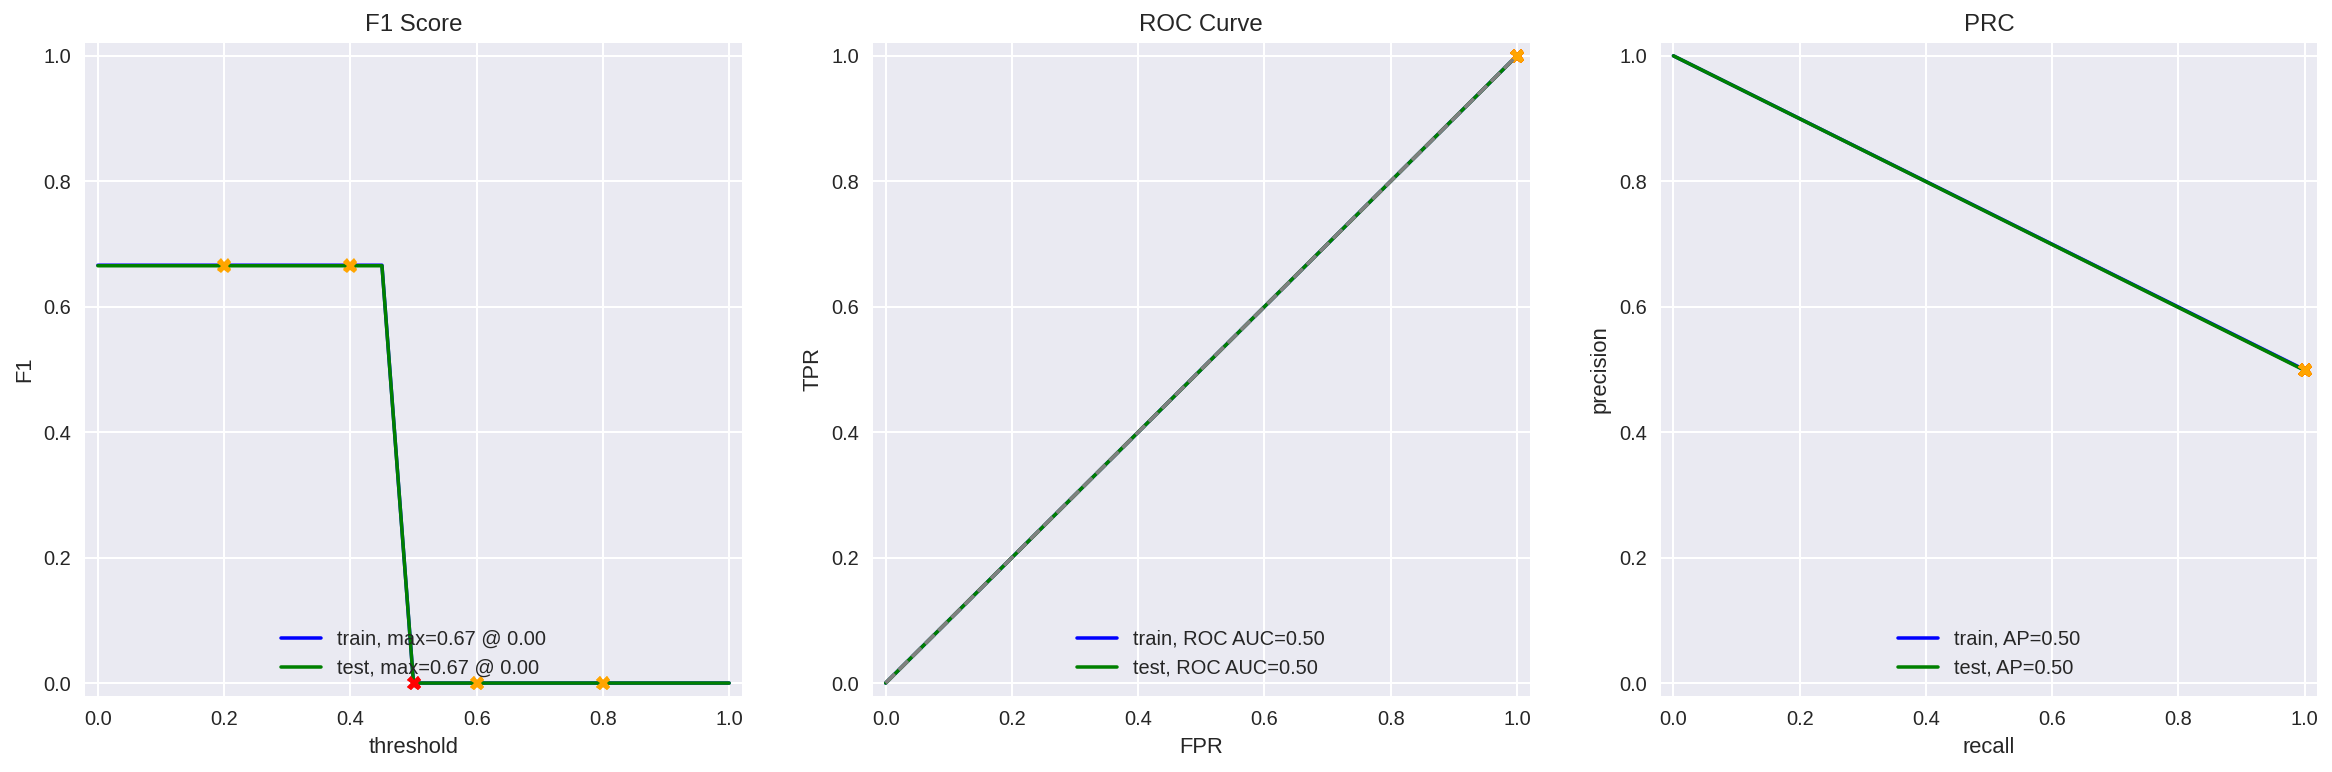

In [25]:
evaluate_model(best_dc_model, df_reviews_train['reviews_norm'], train_target, df_reviews_test['reviews_norm'], test_target)

As expected, the Dummy Classifier performs about as well as flipping a coin.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [26]:
def text_preprocessing_1(text):
    """
    Word tokenize and lemmatize text
    """
    tokens = word_tokenize(text)
    return " ".join(lemmatizer.lemmatize(token) for token in tokens)

In [27]:
df_reviews_train['reviews_nltk'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_1)
df_reviews_test['reviews_nltk'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_1)

In [28]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
train_X = tfidf_vectorizer_1.fit_transform(df_reviews_train['reviews_nltk'])
test_X = tfidf_vectorizer_1.transform(df_reviews_test['reviews_nltk'])

In [29]:
lr = LogisticRegression()
best_lr_model, best_lr_f1, best_lr_time = build_model(lr, train_X, train_target, 
                                                        test_X, test_target,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [30]:
# test set - using nltk

best_lr_f1

0.8805154903132201

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


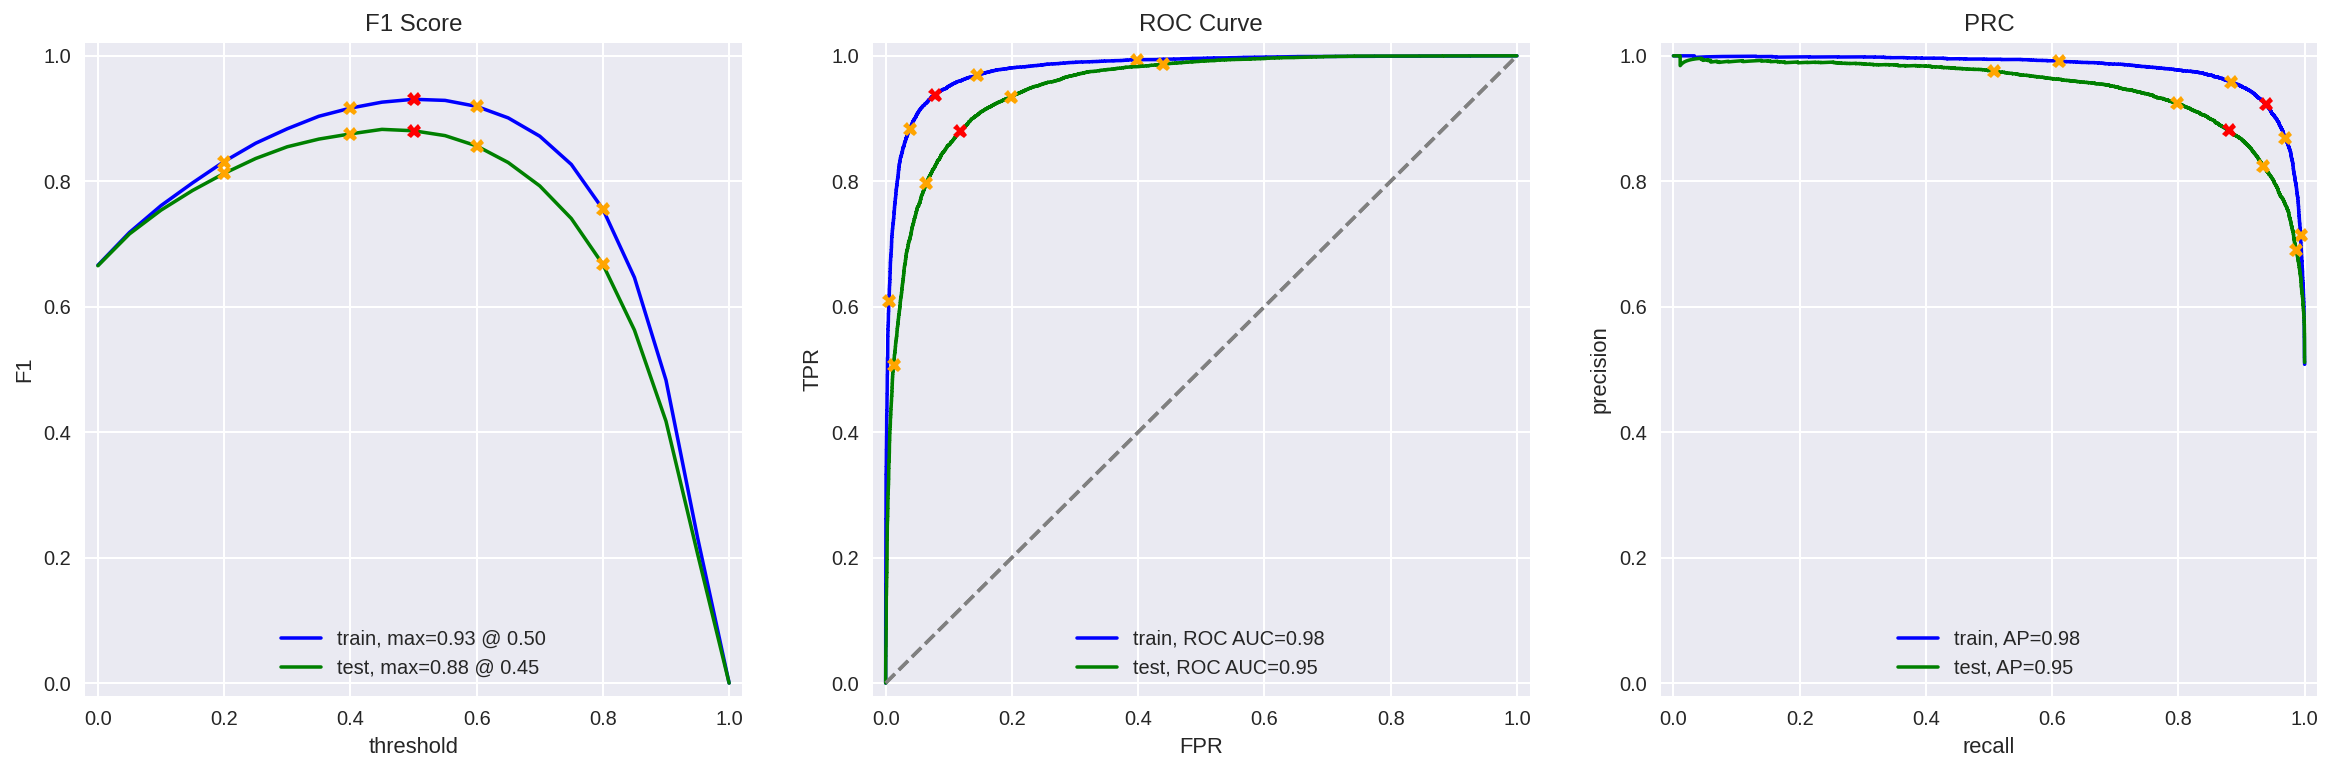

In [31]:
evaluate_model(best_lr_model, train_X, train_target, test_X, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [32]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [34]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
df_reviews_train['reviews_spacy'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_3)
df_reviews_test['reviews_spacy'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_3)

In [35]:
train_X = tfidf_vectorizer_3.fit_transform(df_reviews_train['reviews_spacy'])
test_X = tfidf_vectorizer_3.transform(df_reviews_test['reviews_spacy'])

In [36]:
lr = LogisticRegression()
best_lr_spacy_model, best_lr_spacy_f1, best_lr_spacy_time = build_model(lr, train_X, train_target, 
                                                        test_X, test_target,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [37]:
# test set- using spacy

best_lr_spacy_f1

0.8785197788175245

          train  test
Accuracy   0.92  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


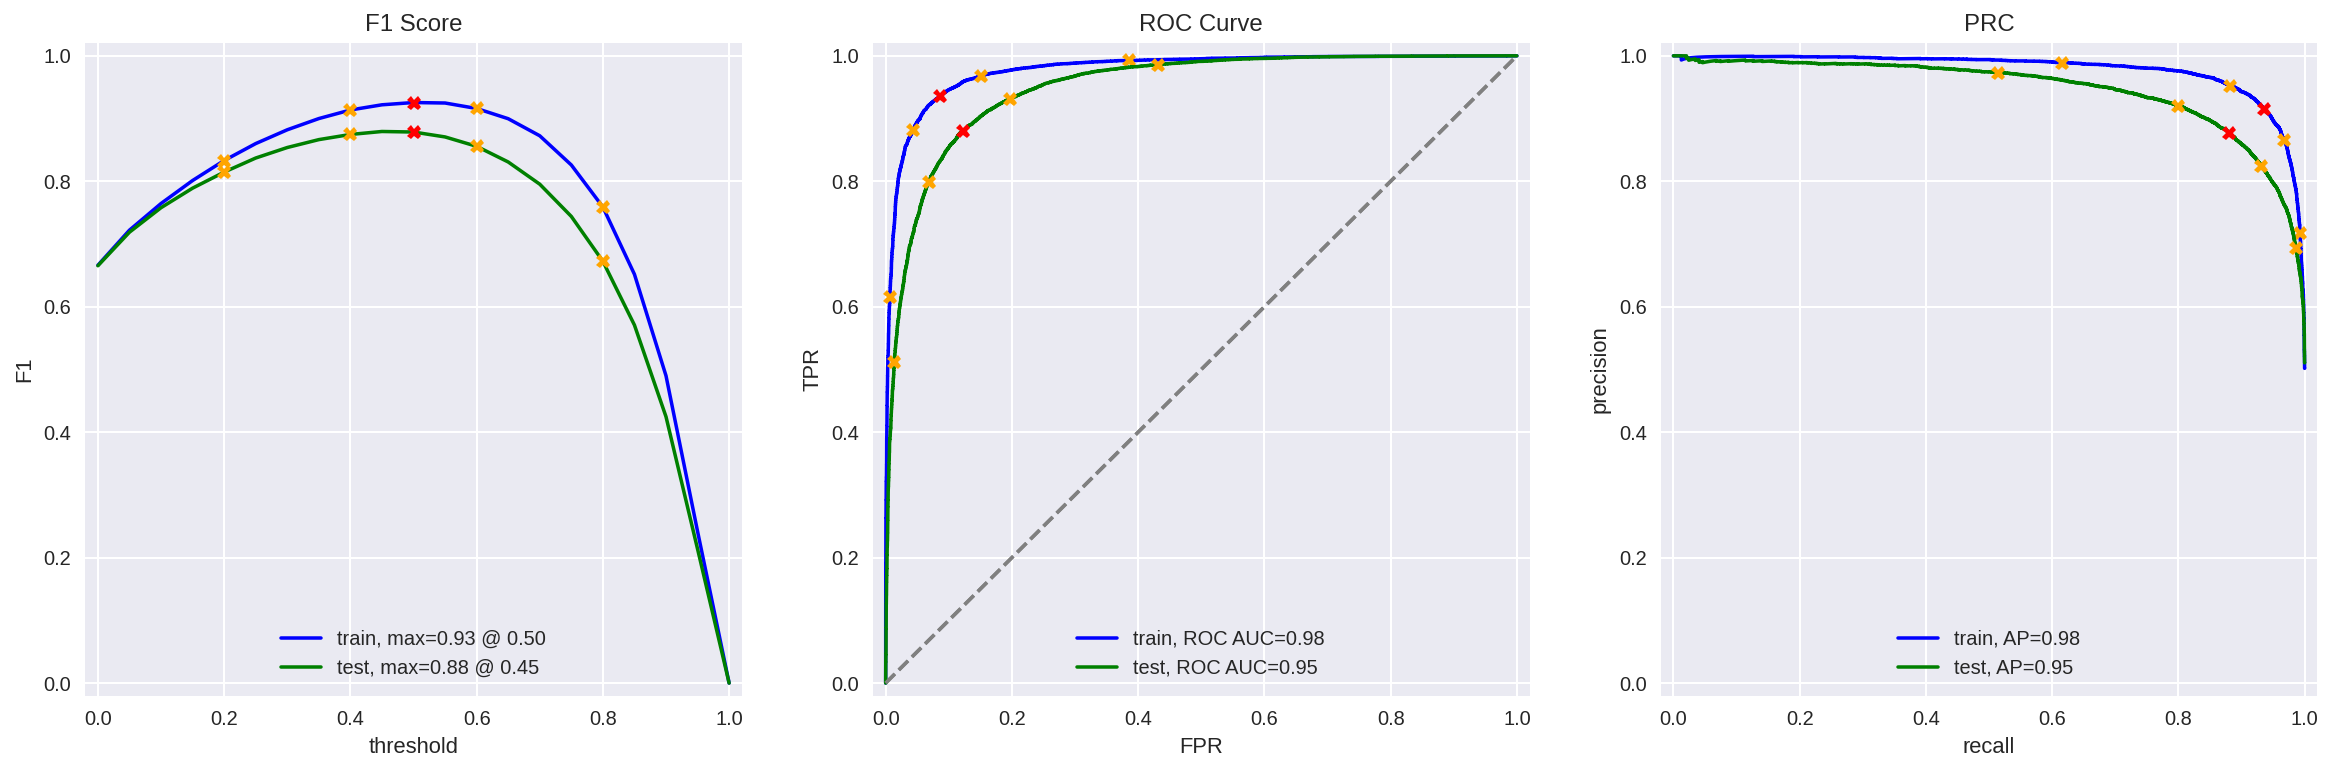

In [38]:
evaluate_model(best_lr_spacy_model, train_X, train_target, test_X, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [39]:
lgbm = LGBMClassifier(learning_rate=0.1, boosting_type='gbdt',
                      objective='binary',
                      feature_fraction=0.8,
                      random_state=1357)
best_lgbm_model, best_lgbm_f1, best_lgbm_time = build_model(lgbm, train_X, train_target, 
                                                        test_X, test_target,
                                                        hyperparameters={'n_estimators': range(100, 600, 100)}, 
                scoring='f1_weighted', cv=3, model_str='lgbm',
           cat_features=[])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

In [40]:
# test set- using spacy

best_lgbm_f1

0.8708647336824626

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.95


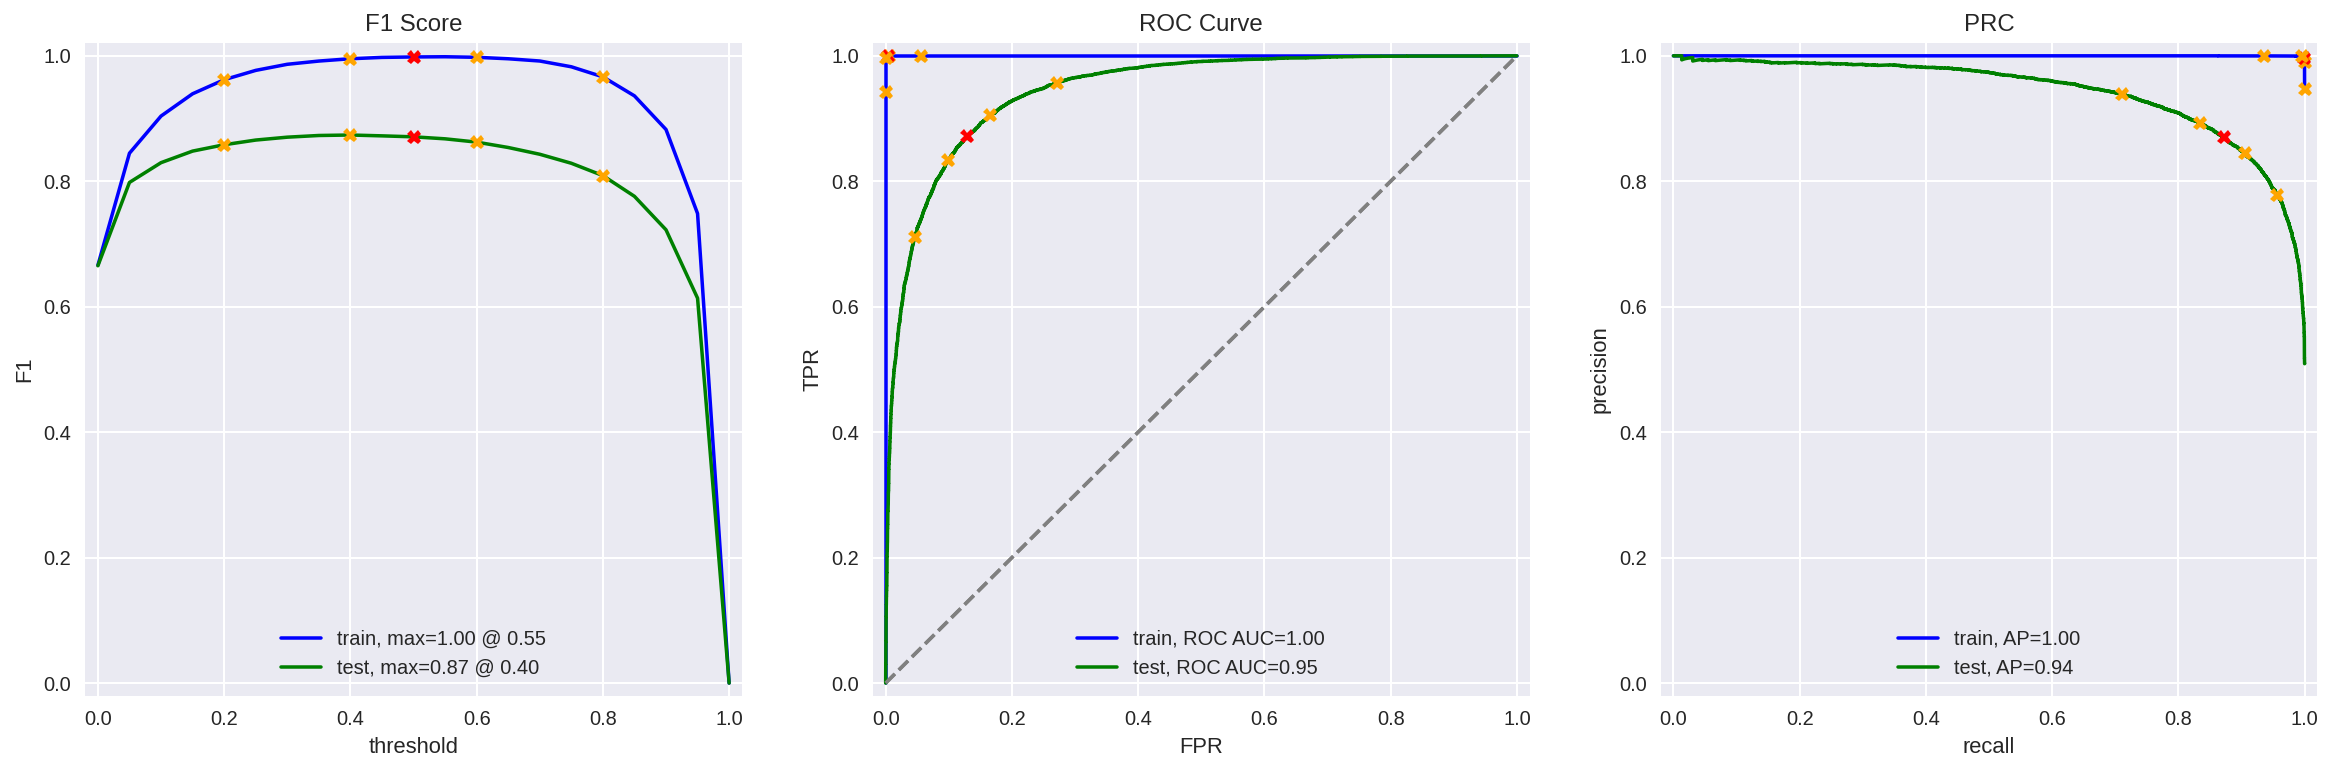

In [41]:
evaluate_model(best_lgbm_model, train_X, train_target, test_X, test_target)

###  Model 9 - BERT

In [42]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [44]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['reviews_norm'])

In [45]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [47]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [49]:
#lr = LogisticRegression()
#best_bert_model, best_bert_f1, best_bert_time = build_model(lr, train_features_9, train_y, 
                                                        #test_features_9, test_y,
                                                        #hyperparameters={'C' : [.01, .1, 1, 10]}, 
                #scoring='f1_weighted', cv=5)

In [50]:
# test set- using bert

#best_bert_f1

In [51]:
#evaluate_model(best_bert_model, train_features_9, train_target, test_features_9, test_target)

In [52]:
#model_results_df = pd.DataFrame({'model': ['LogisticRegression-NLTK', 'LogisticRegression-Spacy', 'LGBMClassifier', 
                                          #'LogisticRegression-BERT'],
              #'best_f1': [best_lr_f1, best_lr_spacy_f1, best_lgbm_f1, best_bert_f1],
              #'train_time': [best_lr_time, best_lr_spacy_time, best_lgbm_time, best_bert_time]})

In [54]:
#model_results_df

## My Reviews

In [56]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_reviews)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [59]:
texts = my_reviews['review_norm']

model_2 = best_lr_model

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie 
0.18:  well i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.33:  i didn't expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [60]:
texts = my_reviews['review_norm']

model_3 = best_lr_spacy_model

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.22:  i did not simply like it not my kind of movie 
0.12:  well i was bored and felt asleep in the middle of the movie 
0.51:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didn't expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [61]:
texts = my_reviews['review_norm']

model_4 = best_lgbm_model

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.49:  i did not simply like it not my kind of movie 
0.18:  well i was bored and felt asleep in the middle of the movie 
0.62:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn't expect the reboot to be so good writers really cared about the source material
0.73:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.93:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 9

In [64]:
#texts = my_reviews['review_norm']

#model_9 = best_bert_model

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
    #print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

 - The DummyClassifier, as expected, produces an F1 score of 50%, which is as good as flipping an unbiased coin.
 - Comparing the LogisticRegression models with NLTK used for preprocessing and Spacy for preprocessing, the model with reviews preprocesed using NLTK, comes out at the top with best f1 score of 88%.
 - Both the models were trained using 5 fold cross-validation with hyperparameter tuning on the C parameter.
 - The LightGBM model turned out to have a lower f1 score, and it took more than two hours to complete training.

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions